In [1]:
from copy import deepcopy
from pathlib import Path

import cheetah
import matplotlib.pyplot as plt

In [2]:
lattice_file_path = (
    Path("$LCLS_LATTICE") / "bmad" / "models" / "cu_hxr" / "cu_hxr.lat.bmad"
)
lattice_file_path

PosixPath('$LCLS_LATTICE/bmad/models/cu_hxr/cu_hxr.lat.bmad')

In [3]:
lattice_dir = str((Path(".").absolute().parent / "lcls-lattice"))

In [4]:
segment = cheetah.Segment.from_bmad(
    str(lattice_file_path), environment_variables={"LCLS_LATTICE": lattice_dir}
)
segment = segment.flattened()
segment

Segment([Drift(length=-0.87, name="dl00"), Drift(length=0.87, name="loadlock"), Marker(is_active=False, is_skippable=True, name='beggun', device='cpu', length=0), Solenoid(length=0.00, k=0.00, name="sol1bk"), Marker(is_active=False, is_skippable=True, name='dbmark80', device='cpu', length=0), Marker(is_active=False, is_skippable=True, name='cathode', device='cpu', length=0), Drift(length=0.10, name="dl01a"), Solenoid(length=0.20, k=0.00, name="sol1"), Drift(length=0.08, name="dl01a1"), Marker(is_active=False, is_skippable=True, name='vv01', device='cpu', length=0), Drift(length=0.12, name="dl01a2"), Marker(is_active=False, is_skippable=True, name='am00', device='cpu', length=0), Drift(length=0.10, name="dl01a3"), Marker(is_active=False, is_skippable=True, name='am01', device='cpu', length=0), Drift(length=0.02, name="dl01a4"), Marker(is_active=False, is_skippable=True, name='yag01', device='cpu', length=0), Drift(length=0.01, name="dl01a5"), Marker(is_active=False, is_skippable=True, n

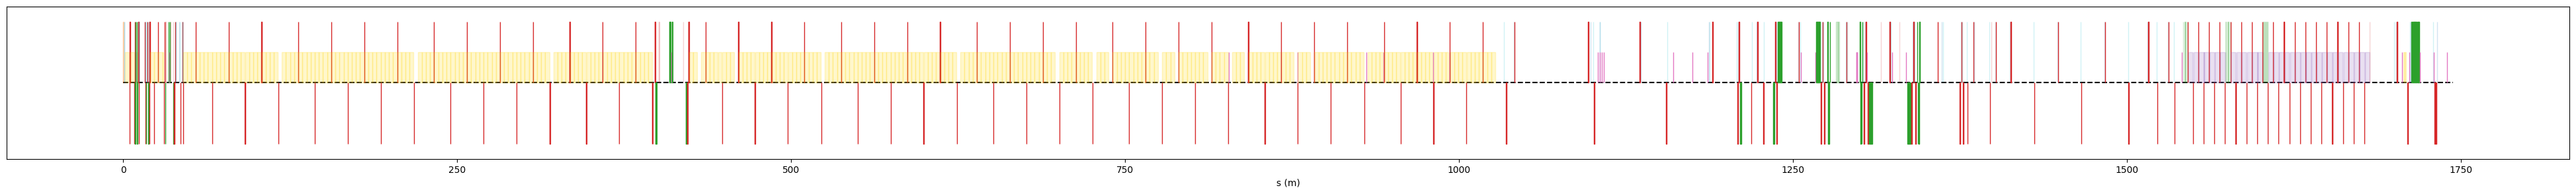

In [5]:
plt.figure(figsize=(50, 3))
segment.plot(ax=plt.gca(), s=0.0)

Drift(length=0.10, name="Drift_003511")
Quadrupole(length=0.10, k1=2.0, misalignment=(0, 0), tilt=0.00, name="Quadrupole_003512")
Drift(length=0.10, name="Drift_003513")


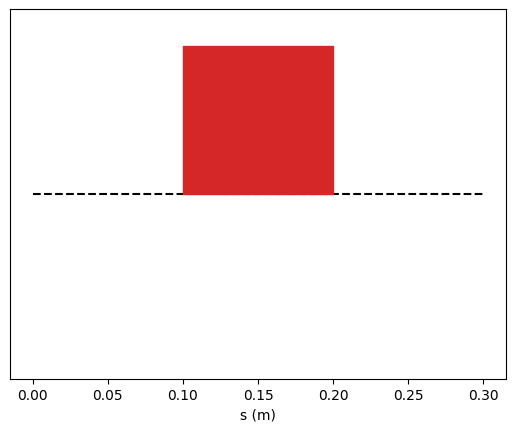

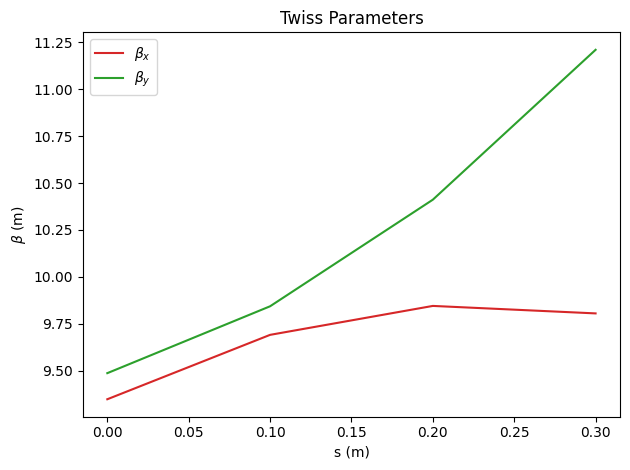

In [6]:
beam = cheetah.ParameterBeam.from_twiss(
    beta_x=9.34799999999386,
    alpha_x=-1.69459999999829,
    emittance_x=3.494768647122823e-09,
    beta_y=9.48702794424903,
    alpha_y=-1.75970623484325,
    emittance_y=3.497810737006068e-09,
)

mini_segment = cheetah.Segment(
    [
        cheetah.Drift(length=0.1),
        cheetah.Quadrupole(length=0.1, k1=2.0),
        cheetah.Drift(length=0.1),
    ]
)

mini_segment.plot(ax=plt.gca(), s=0.0)
mini_segment.plot_twiss(beam)

In [7]:
beam = cheetah.ParameterBeam.from_twiss(
    beta_x=9.34799999999386,
    alpha_x=-1.69459999999829,
    emittance_x=3.494768647122823e-09,
    beta_y=9.48702794424903,
    alpha_y=-1.75970623484325,
    emittance_y=3.497810737006068e-09,
)

# outgoing = segment.track(beam)

segment.plot_twiss(beam)

Drift(length=-0.87, name="dl00")
Drift(length=0.87, name="loadlock")
Marker(is_active=False, is_skippable=True, name='beggun', device='cpu', length=0)
Solenoid(length=0.00, k=0.00, name="sol1bk")
Marker(is_active=False, is_skippable=True, name='dbmark80', device='cpu', length=0)
Marker(is_active=False, is_skippable=True, name='cathode', device='cpu', length=0)
Drift(length=0.10, name="dl01a")
Solenoid(length=0.20, k=0.00, name="sol1")
Drift(length=0.08, name="dl01a1")
Marker(is_active=False, is_skippable=True, name='vv01', device='cpu', length=0)
Drift(length=0.12, name="dl01a2")
Marker(is_active=False, is_skippable=True, name='am00', device='cpu', length=0)
Drift(length=0.10, name="dl01a3")
Marker(is_active=False, is_skippable=True, name='am01', device='cpu', length=0)
Drift(length=0.02, name="dl01a4")
Marker(is_active=False, is_skippable=True, name='yag01', device='cpu', length=0)
Drift(length=0.01, name="dl01a5")
Marker(is_active=False, is_skippable=True, name='fc01', device='cpu', 

RuntimeError: 1D tensors expected, but got 2D and 2D tensors

In [ ]:
segment.flattened()

Segment([Drift(length=-0.87, name="dl00"), Drift(length=0.87, name="loadlock"), Marker(is_active=False, is_skippable=True, name='beggun', device='cpu', length=0), Solenoid(length=0.00, k=0.00, name="sol1bk"), Marker(is_active=False, is_skippable=True, name='dbmark80', device='cpu', length=0), Marker(is_active=False, is_skippable=True, name='cathode', device='cpu', length=0), Drift(length=0.10, name="dl01a"), Solenoid(length=0.20, k=0.00, name="sol1"), Drift(length=0.08, name="dl01a1"), Marker(is_active=False, is_skippable=True, name='vv01', device='cpu', length=0), Drift(length=0.12, name="dl01a2"), Marker(is_active=False, is_skippable=True, name='am00', device='cpu', length=0), Drift(length=0.10, name="dl01a3"), Marker(is_active=False, is_skippable=True, name='am01', device='cpu', length=0), Drift(length=0.02, name="dl01a4"), Marker(is_active=False, is_skippable=True, name='yag01', device='cpu', length=0), Drift(length=0.01, name="dl01a5"), Marker(is_active=False, is_skippable=True, n

In [ ]:
segment.flattened().length

1744.1985952798932

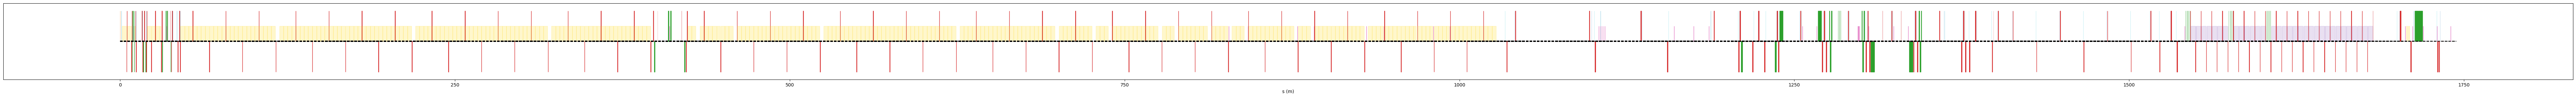

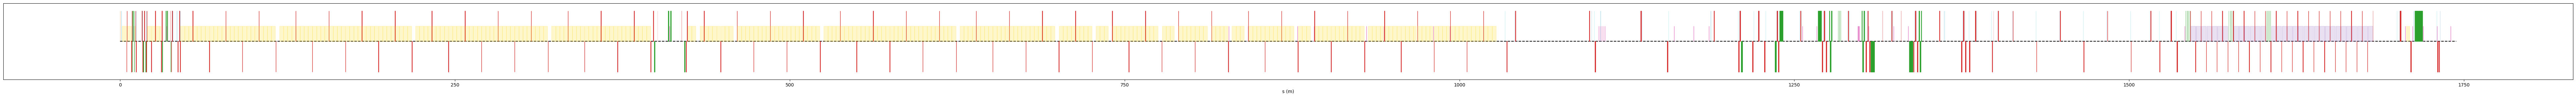

In [ ]:
plt.figure(figsize=(100, 3))
segment.flattened().plot(ax=plt.gca(), s=0.0)